<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
import shutil

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


<h3>Get the data and copy it to S3</h3>

In [3]:
## Setup Sagemaker Session and default buckets
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.session.get_execution_role()
region = sagemaker_session.boto_region_name

bucket_path = f's3://{bucket}/'
print(f'Bucket Path: {bucket_path}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Bucket Path: s3://sagemaker-us-east-1-366182757343/


In [5]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
os.remove('dogImages.zip')
sync_command = f'aws s3 sync ./dogImages {bucket_path}'
!{sync_command}
shutil.rmtree('dogImages')

<h3>Set up parameters, estimator, and tuner</h3>

In [4]:
#setup data paths
os.environ['SM_CHANNEL_TRAINING']= bucket_path
os.environ['SM_MODEL_DIR']=f'{bucket_path}model/'
os.environ['SM_OUTPUT_DATA_DIR']=f'{bucket_path}output/'

data_channels = {
    'train': f'{bucket_path}train/',  # Replace with your S3 path for training data
    'valid': f'{bucket_path}valid/', # Replace with your S3 path for validation data
    'test': f'{bucket_path}test/'
}
model_dir = f'{bucket_path}model/'
output_dir = f'{bucket_path}output/'
print(data_channels)
print(output_dir)

{'train': 's3://sagemaker-us-east-1-366182757343/train/', 'valid': 's3://sagemaker-us-east-1-366182757343/valid/', 'test': 's3://sagemaker-us-east-1-366182757343/test/'}
s3://sagemaker-us-east-1-366182757343/output/


In [74]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [75]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    instance_count=1,
    framework_version="1.8",
    py_version="py36",
    instance_type="ml.m5.large",
    output_path=output_dir,
    hyperparameters={
        'model_dir': model_dir,
        'output_dir': output_dir
    }
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


<h3>Fit the tuner</h3>

In [76]:
tuner.fit(wait=True, inputs=data_channels, include_cls_metadata=False)

Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [77]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-231115-1830')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""256""",0.025876,pytorch-training-231115-1830-001-37256029,Completed,975.0,2023-11-15 18:32:19+00:00,2023-11-15 19:09:35+00:00,2236.0
0,"""64""",0.087931,pytorch-training-231115-1830-002-a3155e73,Completed,292.0,2023-11-15 19:12:56+00:00,2023-11-15 19:46:50+00:00,2034.0


## Imp: If kernel dies, how to continue from a completed training job

In [8]:
#BetterTrainingJobName='pytorch-training-210623-2156-001-fdd5e081'
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
#my_estimator.hyperparameters()
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [78]:
best_estimator=tuner.best_estimator()


2023-11-15 19:46:53 Starting - Found matching resource for reuse
2023-11-15 19:46:53 Downloading - Downloading input data
2023-11-15 19:46:53 Training - Training image download completed. Training in progress.
2023-11-15 19:46:53 Uploading - Uploading generated training model
2023-11-15 19:46:53 Completed - Resource released due to keep alive period expiry


In [79]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"64"',
 'learning_rate': '0.08793092883495049',
 'model_dir': '"s3://sagemaker-us-east-1-366182757343/model/"',
 'output_dir': '"s3://sagemaker-us-east-1-366182757343/output/"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2023-11-15-18-30-43-340"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-366182757343/pytorch_dog_hpo-2023-11-15-18-30-43-340/source/sourcedir.tar.gz"'}

In [80]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 64, 'learning_rate': '0.08793092883495049'}

In [5]:
# Just loading in the best parameters from our previous tunning job
tuning_job_name = "pytorch-training-231115-1830"
tuning_job_description = sagemaker_session.sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

print("Tuning job name:", tuning_job_description['HyperParameterTuningJobName'])
print("Tuning job status:", tuning_job_description['HyperParameterTuningJobStatus'])
print("Best training job name:", tuning_job_description['BestTrainingJob']['TrainingJobName'])

best_hyperparameters = tuning_job_description['BestTrainingJob']['TunedHyperParameters']
hyperparameters = {"batch_size": int(best_hyperparameters['batch_size'].replace('"', '')), \
                   "learning_rate": best_hyperparameters['learning_rate']}
hyperparameters['model_dir'] = model_dir
hyperparameters['output_dir'] = output_dir
hyperparameters

Tuning job name: pytorch-training-231115-1830
Tuning job status: Completed
Best training job name: pytorch-training-231115-1830-002-a3155e73


{'batch_size': 64,
 'learning_rate': '0.08793092883495049',
 'model_dir': 's3://sagemaker-us-east-1-366182757343/model/',
 'output_dir': 's3://sagemaker-us-east-1-366182757343/output/'}

In [83]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [84]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<h2>Creating an Estimator</h2>

In [15]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    instance_count=1,
    framework_version="1.8",
    py_version="py36",
    instance_type="ml.m5.large",
    output_path=output_dir,
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [16]:
estimator.fit(wait=True, inputs=data_channels, include_cls_metadata=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-11-13-23-22-57-571


<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [6]:
### Training Setup

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    instance_count=2,
    framework_version="1.8",
    py_version="py36",
    instance_type="ml.m5.large",
    output_path=output_dir,
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    # rules = rules,
    # debugger_hook_config=hook_config,
    # profiler_config=profiler_config,
)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [7]:
### Training Execution
import time
tic = time.perf_counter()
print(f'timing starting at: {tic}')

estimator.fit(wait=True, inputs=data_channels)


toc = time.perf_counter()
print(f'timing ended at: {toc}')
print(f'total training duration: {tic - toc}')

timing starting at: 535.05523965
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-11-16-11-40-04-578


2023-11-16 11:40:05 Starting - Starting the training job...
2023-11-16 11:40:20 Starting - Preparing the instances for training......
2023-11-16 11:41:30 Downloading - Downloading input data............
2023-11-16 11:43:20 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-11-16 11:43:49,065 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-11-16 11:43:49,068 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-11-16 11:43:49,083 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-11-16 11:43:49,087 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-11-16 11:43:49,315 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-11-16 11:43:49,337 sagemaker-training-toolkit INFO     No GPUs detected (n

In [8]:
print(f'Total time in min: {2269/60}')

Total time in min: 37.81666666666667


<h2>Deployment</h2>

In [4]:
# model_location=estimator.model_data
# model_location
model_location = 's3://sagemaker-us-east-1-366182757343/output/pytorch-training-2023-11-16-11-40-04-578/output/model.tar.gz' #multi instance training model
# model_location = "s3://sagemaker-us-east-1-366182757343/dog-pytorch-2023-11-13-23-22-57-571/output/model.tar.gz" #single instance training model

In [5]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [6]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [7]:
pytorch_model = PyTorchModel(
    model_data=model_location,
    role=role,
    entry_point='infernce2.py',
    py_version="py36",
    framework_version="1.8",
    predictor_cls=ImagePredictor
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [8]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
-----!

In [7]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

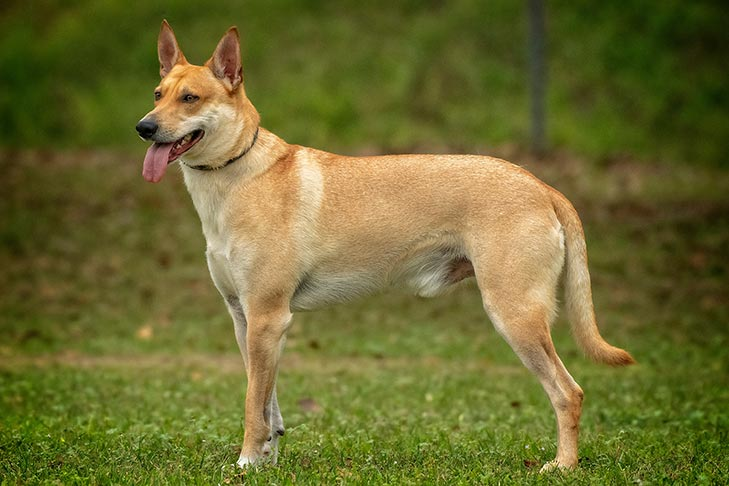

In [8]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [21]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [22]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [23]:
type(response2[0][0])

float

In [24]:
response2[0]

[0.5792363882064819,
 0.7636755108833313,
 0.1653096079826355,
 0.4950832724571228,
 0.8176630735397339,
 0.7240684628486633,
 0.5346078872680664,
 0.3285769522190094,
 -0.10185138136148453,
 0.2920922338962555,
 0.6372276544570923,
 0.5812382698059082,
 -0.08509815484285355,
 0.37544023990631104,
 0.8461633324623108,
 0.021534280851483345,
 0.10557816922664642,
 0.19371265172958374,
 0.14003700017929077,
 0.3003043234348297,
 0.41529303789138794,
 0.00643235445022583,
 0.1804734468460083,
 0.6603132486343384,
 -0.030782438814640045,
 -0.09654703736305237,
 0.5044122338294983,
 -0.022909216582775116,
 0.6699318885803223,
 0.615969181060791,
 0.6364791393280029,
 0.7549263834953308,
 -0.024541690945625305,
 0.07810435444116592,
 0.3004719018936157,
 0.5528291463851929,
 0.3313681483268738,
 0.6378064751625061,
 0.5468197464942932,
 0.40666159987449646,
 0.762763500213623,
 0.6268402338027954,
 0.35572952032089233,
 0.5318848490715027,
 0.17492461204528809,
 0.7221673727035522,
 0.603868

In [25]:
import torch
import numpy as np
np.argmax(response, 1)

array([14])

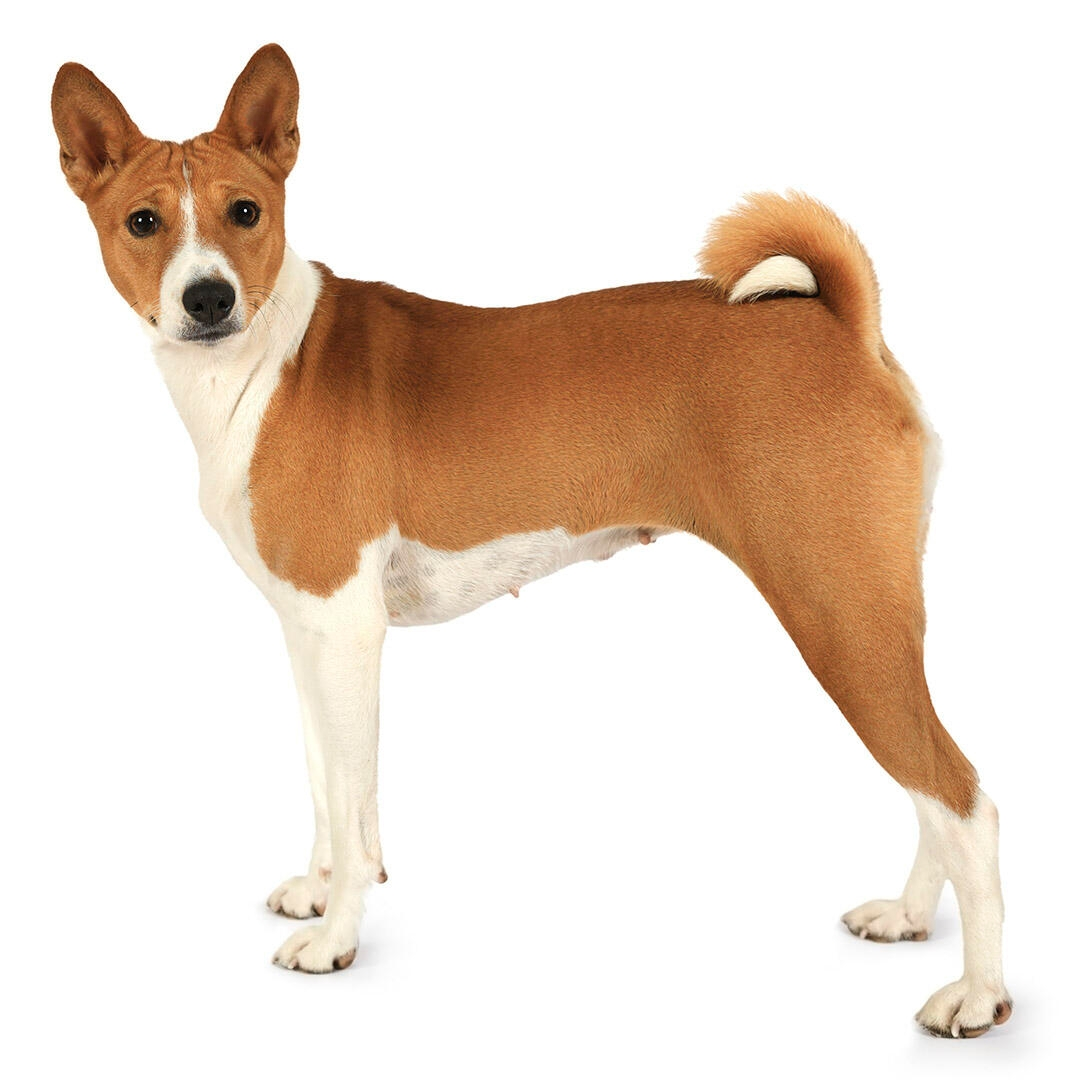

In [9]:
## Results 
# Categroy 14 is a Basenji which from my persepetion looks pretty close to the example dog
request_dict={ "url": "https://www.purina.co.uk/sites/default/files/styles/square_medium_440x440/public/2022-07/Basenji.jpg" }

img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))